In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# %reload_ext autoreload

In [37]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import skimage as sk
import numpy as np
import homography, rectification, filters, my_types, utils

# input files

In [38]:
DATA = Path("data")
OUTDIR = Path("output")

In [39]:
name  = "car"
im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")

In [40]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = DATA / (im1_name.stem + "_w.jpg")
warp2_name = DATA / (im2_name.stem + "_w.jpg")

pts1_name = DATA / (im1_name.stem + "_w.pkl")
pts2_name = DATA / (im2_name.stem + "_w.pkl")

In [41]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

# Pick Correspondences

In [42]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [43]:
try:
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
except:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 4)
    im2_pts = utils.pick_points(im2_name, 4)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    %matplotlib inline

In [44]:
im1_pts = im1_pts[:4]
im2_pts = im2_pts[:4]

In [45]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print("input shape = ", im1.shape)
    print("target shape = ", h / r, w / r)

RESIZE = False


In [46]:
if RESIZE:
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts /= r
    im2_pts /= r

im1.shape

(750, 1000, 3)

In [47]:
# im2_pts = np.array([[336.39113737, 319.88745103], [157.08706851, 513.07312521], [469.42318845, 393.92267946], [121.22625474, 407.80428479]])

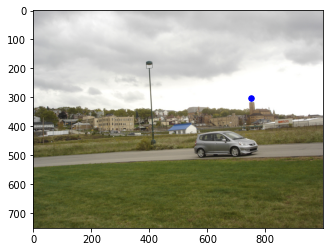

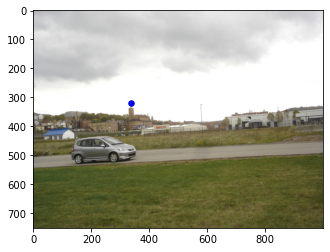

In [48]:
utils.plot_pts(im1, im1_pts[:1])
utils.plot_pts(im2, im2_pts[:1])

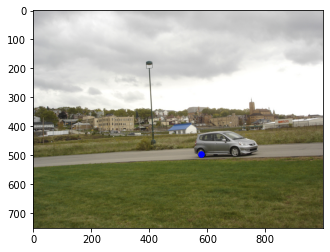

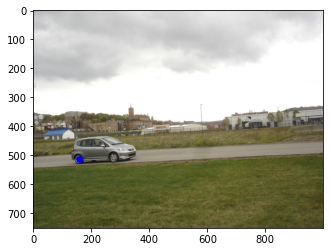

In [49]:
utils.plot_pts(im1, im1_pts[1:2])
utils.plot_pts(im2, im2_pts[1:2])

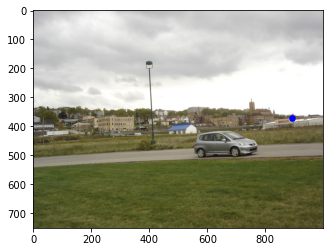

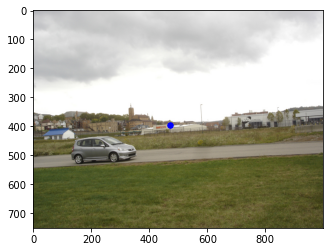

In [50]:
utils.plot_pts(im1, im1_pts[2:3])
utils.plot_pts(im2, im2_pts[2:3])

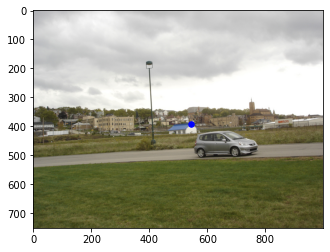

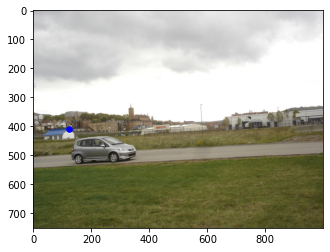

In [51]:
utils.plot_pts(im1, im1_pts[3:4])
utils.plot_pts(im2, im2_pts[3:4])

In [52]:
im1_pts

array([[751.92228244, 302.90525616],
       [577.05777687, 494.64265262],
       [893.04100624, 371.93071889],
       [543.31199509, 390.33750895]])

In [53]:
im2_pts

array([[336.39113737, 319.88745103],
       [157.08706851, 513.07312521],
       [469.42318845, 393.92267946],
       [121.22625474, 407.80428479]])

# Image Rectification

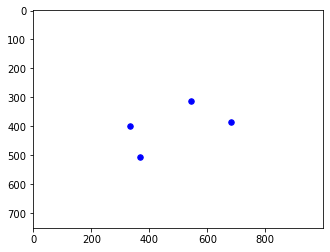

In [54]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    %matplotlib tk
    plane_pts = utils.pick_points(im1, 4)
    %matplotlib inline
    # plane_pts = (im1_pts + im2_pts) / 2
    utils.save_points(plane_pts, plane_name)

if RESIZE:
    plane_pts /= r

canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

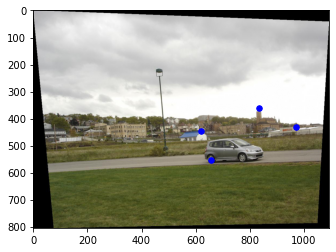

In [55]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

utils.plot_pts(warp1, warp_pts1)

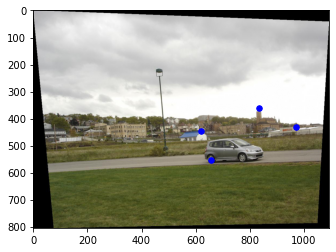

In [56]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

utils.plot_pts(warp1, warp_pts1)

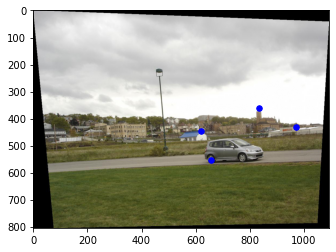

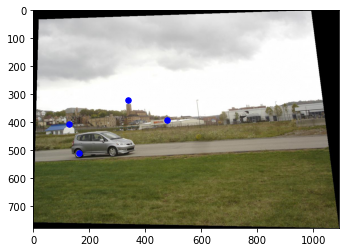

In [57]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

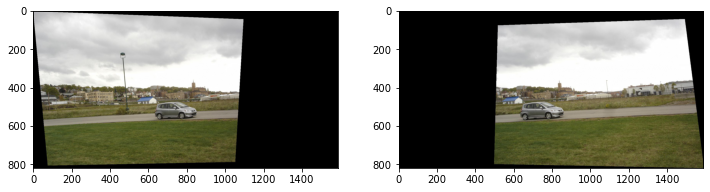

In [58]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

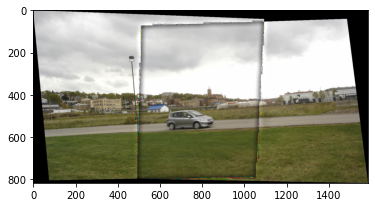

In [115]:
blended = rectification.alpha_blend(aligned1, aligned2)
plt.imshow(blended)
plt.imsave(mosaic_name, blended)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(818, 1587, 3)


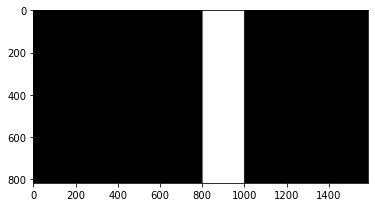

In [124]:
smooth = np.zeros_like(left, dtype=np.float)
rep = np.tile(rep, (3, 1, 1)).transpose((1, 2, 0))
smooth[:, 600:1000] = rep
print(smooth.shape)
plt.imshow(smooth)

In [121]:
left, right = aligned1, aligned2
mask = rectification.overlap(left, right)
# mask = mask * (left > 0)
print(mask.dtype)
print(mask.shape)

float64
(818, 1587, 3)


In [122]:
# l, r = int(np.floor(np.min(int_pts[:, 1]))), int(np.ceil(np.max(int_pts[:, 1])))
# print(l, r)
rep = np.repeat(np.linspace(-30, 30, 400, dtype=np.single), left.shape[0]).reshape(-1, left.shape[0]).T
rep.shape

(818, 400)

In [123]:
rep

array([[-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ],
       [-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ],
       [-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ],
       ...,
       [-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ],
       [-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ],
       [-30.      , -29.849625, -29.699247, ...,  29.699247,  29.849625,
         30.      ]], dtype=float32)

In [125]:
import scipy
smooth = scipy.special.expit(smooth)*mask
res = left * (1 - smooth) + right * (1 - mask + smooth)
# res = np.clip(res, 0, 255).round().astype(np.uint8)

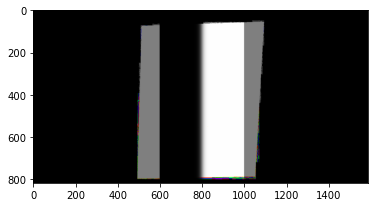

In [126]:
plt.imshow(smooth)

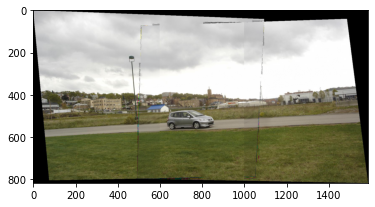

In [129]:
plt.imshow(res)
plt.imsave(OUTDIR/"test.jpg", res)